## Data exploration


In [0]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
f_ = drive.CreateFile({'id': '1UJDXBrLmpfFL1C9mAdxi-klHs48gtHTv'})
f_.GetContentFile('train.csv')

In [0]:
import pandas as pd
df = pd.read_csv('train.csv')

In [0]:
import re
import seaborn as sns
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
# Samples
df.question_text[df.target == 1].sample(5).to_list()

['How do people get into treasonous groups like the one Whoopi Goldberg promotes and protests with?',
 'Your organisation support groups who advocate violence, whereas Coptic Christians in Egypt are suffering terrorist attacks. Is it not your duty to stand with suffering Christians instead of supporting those who oppress them?',
 'Why do people believe in evolution, when it is clearly not true?',
 'Why do Koreans reject their Tamil origins?',
 'CareOnGo has been able to achieve 15K+ mobile downloads for their app in 4 weeks. Can anyone suggest what marketing they have done or is because of their awesome app?']

In [0]:
# Samples
df.question_text[df.target == 0].sample(5).to_list()

['Is it possible to come back from years of alcohol addiction?',
 'Why would one’s sexual preferences be influenced by their religious convictions?',
 'What is the link between control freaks and owning cats?',
 'How is the life of a student at IIM C?',
 'Why are some web forms so difficult to use on a mobile device, and how do you fix that problem?']

## Basic data preparation


In [0]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
nltk.download('wordnet')


def filter_numerical(sentence):
  return re.sub(r'\b\d+(?:\.\d+)?\s+', '', sentence)

def remove_punctuation(sentence):
    return re.sub(r'[^\w\s]', '', sentence)

def filter_stopwords(sentence):
  return [word for word in sentence if word not in stopwords]

def lemmatize_text(sentence):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in sentence]

def stem_text(sentence):
    ps = PorterStemmer()
    return [ps.stem(word) for word in sentence]

df['processed'] = df['question_text'].apply(filter_numerical)
df['processed'] = df['processed'].apply(remove_punctuation)

df['processed'] = df['processed'].apply(word_tokenize)
df['processed'] = df['processed'].apply(filter_stopwords)
df['processed'] = df['processed'].apply(lemmatize_text)
df['processed'] = df['processed'].apply(stem_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Explanatory analysis


In [0]:
# Imbalanced
df.target.value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vec = TfidfVectorizer(min_df=3,
                             max_features = 50_000,
                             analyzer="word",
                             ngram_range=(1,3),
                             stop_words="english")
tf_idf = tf_idf_vec.fit_transform(list(df["processed"].map(lambda tokens: " ".join(tokens))))

In [0]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=3, random_state=42)
svd_tfidf = svd.fit_transform(tf_idf)
print("Dimensionality of LSA space: {}".format(svd_tfidf.shape))

Dimensionality of LSA space: (1306122, 3)


No handles with labels found to put in legend.


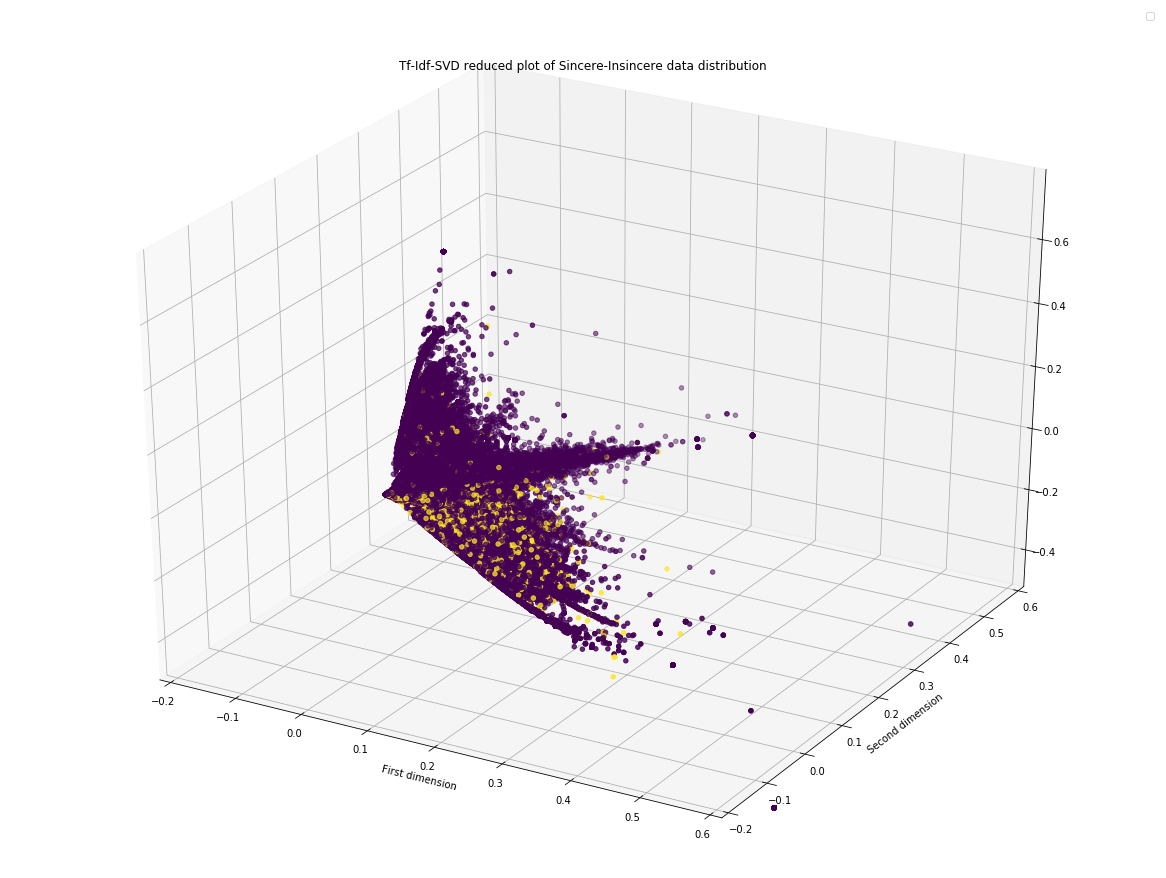

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
# Showing scatter plots 
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16,12))

# Plot models: c = df.target.values,
ax = Axes3D(fig) 
ax.scatter(svd_tfidf[:,0],
           svd_tfidf[:,1],
           svd_tfidf[:,2],
           c = df.target.values,
           marker='o')
plt.title("Tf-Idf-SVD reduced plot of Sincere-Insincere data distribution")
plt.xlabel("First dimension")
plt.ylabel("Second dimension")
plt.legend()
plt.xlim(-0.2, 0.6)
plt.ylim(-0.2, 0.6)
plt.show()
fig.savefig("lsa_plot.png")

In [0]:
# Calculate sentiment
from textblob import TextBlob

df['polarity'] = df['processed'].map(lambda text: TextBlob(" ".join(text)).sentiment.polarity)
df['len'] = df['processed'].apply(lambda x: len(" ".join(x)))

In [0]:
from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.figsize'] = 16, 8

plt.subplot(1, 2, 1)
plt.hist(df.polarity[df.target == 0], color='pink', density=True)
plt.title("Sentiment polarity. Genuine questions")

plt.subplot(1, 2, 2)
plt.hist(df.polarity[df.target == 1], color = "darkviolet", density=True)
plt.title("Sentiment polarity. Toxic questions")

Text(0.5, 1.0, 'Sentiment polarity. Genuine questions')

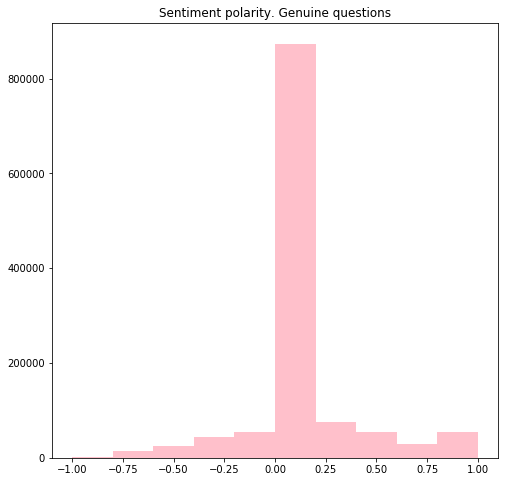

In [0]:
plt.hist(df.polarity[df.target == 0], color='pink')
plt.title("Sentiment polarity. Genuine questions")

In [0]:
# TOxic questions with negative sentiment
df.sort_values(by='polarity', ascending=True)[df.target==1].head(10).question_text.to_list()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


["Will tampered EVM'S be remembered by future generations as the worst period for having Modi as PM for 5 years?",
 "Why is Riley Reid number 1 on pornhub? She's ugly and her body is one of the worst I've seen.",
 'Was Hitler evil at all?',
 'Who is more evil, Hillary Clinton or Adolf Hitler?',
 'Why is M K Gandhi evil?',
 'Why do Danes have the worst fashion style in the world?',
 "What are some experiences you've had that lead you to believe women are evil?",
 'How do the California residents feel about being rated worst quality of life state in the United States?',
 'Was Hitler evil or misunderstood?',
 "In the future will it be universally accepted that the creation of Israel and events after it were evil, in the same way that it's universally accepted that the colonization of the Americas is evil? Why?"]

In [0]:
df[(df.polarity == 1) & (df.target==0)].sample(10).question_text.to_list()

['Which are the best web hosting Christmas offers 2017?',
 'How can I convince my best friend to be careful around strangers?',
 'What was the best fighter plane ever?',
 'Who are the best NYC recruiters for marketing/advertising jobs client side. ',
 'Which is the best naturopathy centre in Hyderabad?',
 'What is the best GUI framework/ library available in Python?',
 'What are best stock advising app?',
 'Which is the best statistics book for Scientists and engineers?',
 'What are the best explanations we have for where the basque language derived from?',
 'What are some best fortified milk brands?']

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df.processed.apply(lambda x: " ".join(x)), 20)
common_words_toxic = get_top_n_words(df.processed[df.target == 1].apply(lambda x: " ".join(x)), 50)
common_words_nontoxic = get_top_n_words(df.processed[df.target == 0].apply(lambda x: " ".join(x)), 50)

In [0]:
for word, freq in common_words:
    print(word, freq)

whi 145275
best 62320
peopl 56627
like 53743
use 47266
good 38909
make 38139
india 32656
think 29278
differ 29123
year 28180
way 27927
time 27469
work 27294
mani 24506
life 23833
want 23593
doe 23293
person 22984
someon 22843


In [0]:
for word, freq in common_words_toxic:
    print(word, freq)

whi 33026
peopl 13016
woman 7086
trump 6538
like 6394
indian 5647
muslim 5394
american 4711
think 4267
men 4225
dont 4156
white 4133
mani 3573
black 3541
girl 3461
quora 3411
countri 3369
india 3294
want 3019
liber 2912
make 2835
hate 2665
sex 2576
world 2482
say 2174
question 2141
chines 2095
support 2094
kill 2027
christian 1982
democrat 1921
feel 1920
know 1868
right 1843
use 1822
presid 1800
believ 1735
america 1707
jew 1678
hindu 1678
doe 1678
gay 1662
child 1632
state 1626
year 1604
donald 1523
true 1514
look 1501
becom 1491
realli 1488


In [0]:
for word, freq in common_words_nontoxic:
    print(word, freq)

whi 112249
best 61660
like 47349
use 45444
peopl 43611
good 37421
make 35304
india 29362
differ 28388
way 26715
year 26576
work 26352
time 25998
think 25011
life 22668
someon 21919
person 21666
doe 21615
mani 20933
want 20574
know 20460
feel 19047
start 18561
becom 18494
mean 18226
thing 18196
job 18141
engin 17820
learn 17707
happen 17639
book 16690
countri 16529
im 15871
need 15731
student 15544
dont 15290
possibl 15261
better 15022
world 14825
univers 14782
compani 14612
day 14459
studi 13982
new 13945
colleg 13698
chang 13448
live 13282
school 13281
quora 12449
friend 12404


In [0]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df.processed.apply(lambda x: " ".join(x)), 20)
for word, freq in common_words:
    print(word, freq)

whi peopl 9598
best way 8584
year old 5603
whi dont 4293
whi mani 3817
unit state 3763
donald trump 3549
look like 3351
feel like 3065
high school 2889
comput scienc 2665
mani peopl 2410
whi indian 2281
social medium 2104
ha anyon 2018
jee main 2014
whi doesnt 1916
north korea 1837
best place 1805
best book 1787


In [0]:
common_words_toxic = get_top_n_bigram(df.processed[df.target == 1].apply(lambda x: " ".join(x)), 20)
for word, freq in common_words:
    print(word, freq)

whi peopl 9598
best way 8584
year old 5603
whi dont 4293
whi mani 3817
unit state 3763
donald trump 3549
look like 3351
feel like 3065
high school 2889
comput scienc 2665
mani peopl 2410
whi indian 2281
social medium 2104
ha anyon 2018
jee main 2014
whi doesnt 1916
north korea 1837
best place 1805
best book 1787


In [0]:
common_words_nontoxic = get_top_n_bigram(df.processed[df.target == 0].apply(lambda x: " ".join(x)), 20)
for word, freq in common_words:
    print(word, freq)

whi peopl 9598
best way 8584
year old 5603
whi dont 4293
whi mani 3817
unit state 3763
donald trump 3549
look like 3351
feel like 3065
high school 2889
comput scienc 2665
mani peopl 2410
whi indian 2281
social medium 2104
ha anyon 2018
jee main 2014
whi doesnt 1916
north korea 1837
best place 1805
best book 1787


In [0]:
# Test sentiment as predictor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)
lr = LogisticRegression(random_state=42, class_weight = 'balanced')
lr.fit(df_train.polarity.values.reshape(-1, 1), df_train.target)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
from sklearn.metrics import f1_score, confusion_matrix as cm 
pred_tr = lr.predict(df_train.polarity.values.reshape(-1, 1))
pred = lr.predict(df_val.polarity.values.reshape(-1, 1))
print(f1_score(df_val.target, pred))
print(cm(df_val.target, pred))

print(f1_score(df_train.target, pred_tr))
print(cm(df_train.target, pred_tr))

0.11188757744097289
[[ 63584 181785]
 [  4144  11712]]
0.11501513733168502
[[253537 726406]
 [ 16668  48286]]


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vec = TfidfVectorizer(min_df=3,
                             max_features = 20_000,
                             analyzer="word",
                             ngram_range=(1,3),
                             stop_words="english")
tf_idf = tf_idf_vec.fit_transform(list(df.processed[df.target == 1].map(lambda tokens: " ".join(tokens))))

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200, random_state=42)
svd_tfidf = svd.fit_transform(tf_idf)

In [0]:
from sklearn.cluster import KMeans

wcss = []
for i in range(2, 12, 2):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(svd_tfidf)
    wcss.append(kmeans.inertia_)

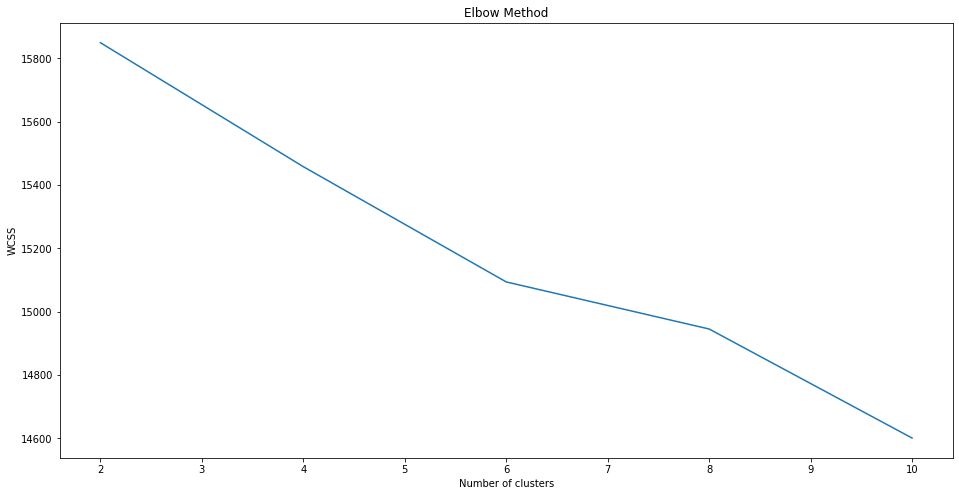

In [0]:
plt.plot(range(2, 12, 2), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [0]:
num_clusters = 9

In [0]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(svd_tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [0]:
centroids = kmeans.cluster_centers_

In [0]:
import numpy as np
# Find 7 closest to centroid questions
def closest_nodes(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return  dist_2.argsort()[0:7]

In [0]:
for i in range(num_clusters):
  indices = closest_nodes(centroids[i], svd_tfidf)
  print(i)
  for ind in indices: 
    print(df[df.target == 1].question_text.to_list()[ind])

0
Why are Shiva devotees and Devi devotees so disrespectful to Lord Vishnu, even though it is Lord Vishnu who suffers all the consequences of Shiva and Brahma's boons?
When I was a sperm, I won the swimming competition against 100 billion other sperm swimmers. Why is no one impressed with my grand achievement?
Why do the professional mathematician’s behaviours tend to degrade any talented amateur mathematician who is never a professional but can definitely beat them publicly in their own fields?
Why is John McCain so revered when his past shenanigans as well as his present actions paint him as total jackass?
IS the ONLY LOTTERY for not upside down? An evangilitacal ownership and if so is there suppose to be a banking document involving chuck yeager and northerly Busscas RESTAURANT AND the rifling union
Is Edward Snowden a computer simulated character produced at Pixar Studios in Hollywood?
Where in the Bay area can I get reliable expert advice on whether serious auto damage is worth re